<a href="https://colab.research.google.com/github/Klop4ikk/3int/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0021 - mae: 0.0320
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.3174e-04 - mae: 0.0179
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.5759e-04 - mae: 0.0179
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.9318e-04 - mae: 0.0169
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.7380e-04 - mae: 0.0197
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.6120e-04 - mae: 0.0177
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.8717e-04 - mae: 0.0153
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.1427e-04 - mae: 0.0177
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.4231e-04 - mae: 0.0161
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.8265e-04 - mae: 0.0178
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
R²: 0.9233, MAE: 913.37, RMSE: 1071.06


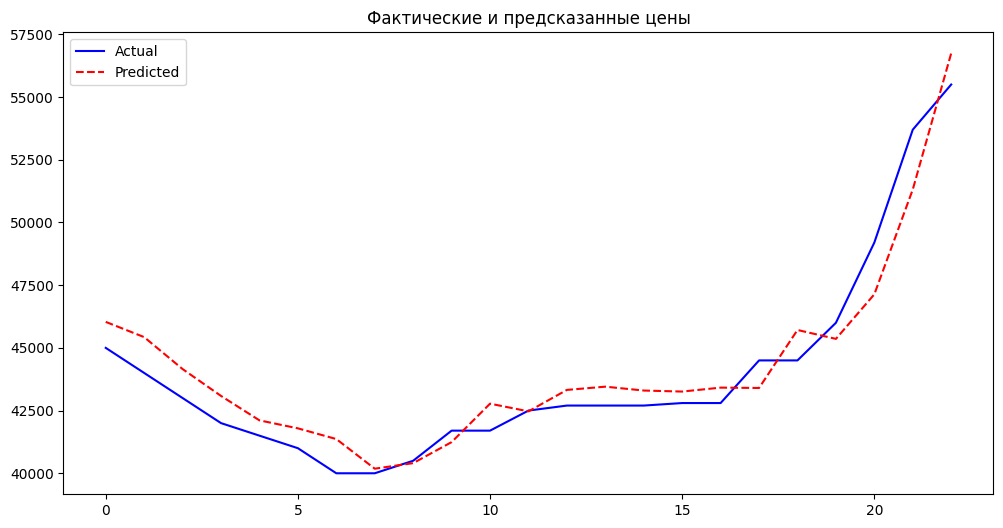

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import requests
from io import BytesIO

# Ссылки на файлы
url_train = "https://github.com/samoletpanfilov/reinforcement_task/raw/refs/heads/master/data/train.xlsx"
url_test = "https://github.com/samoletpanfilov/reinforcement_task/raw/refs/heads/master/data/test.xlsx"

# Функция загрузки данных
def load_data(url):
    response = requests.get(url)
    df = pd.read_excel(BytesIO(response.content), engine='openpyxl')
    return df

# Загружаем данные
train_data = load_data(url_train)
test_data = load_data(url_test)

# Преобразуем даты
train_data.iloc[:, 0] = pd.to_datetime(train_data.iloc[:, 0], errors="coerce")
test_data.iloc[:, 0] = pd.to_datetime(test_data.iloc[:, 0], errors="coerce")

# Проверяем, нет ли NaN после преобразования
if train_data.iloc[:, 0].isna().sum() > 0 or test_data.iloc[:, 0].isna().sum() > 0:
    raise ValueError("Ошибка: Первая колонка не содержит корректные даты!")

# Используем только "Цена на арматуру" для обучения
train_values = train_data.iloc[:, 1].values.reshape(-1, 1)
test_values = test_data.iloc[:, 1].values.reshape(-1, 1)

# Нормализация данных
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_values)
test_scaled = scaler.transform(test_values)

# Создание временных окон
def create_sequences(data, time_step=30):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

time_step = 5  # Размер окна

X_train, y_train = create_sequences(train_scaled, time_step)
X_test, y_test = create_sequences(test_scaled, time_step)

# Проверяем, не пуст ли набор данных
if X_train.shape[0] == 0 or X_test.shape[0] == 0:
    raise ValueError("Ошибка: Временные последовательности пустые. Попробуйте уменьшить time_step.")

# Преобразуем в 3D-формат для GRU/LSTM
X_train = X_train.reshape((X_train.shape[0], time_step, 1))
X_test = X_test.reshape((X_test.shape[0], time_step, 1))

# Загружаем модель
model = load_model("GRU_model.h5")

# Проверяем, совпадает ли размерность входных данных модели
expected_features = model.input_shape[-1]
actual_features = X_train.shape[-1]

if expected_features != actual_features:
    raise ValueError(f"Несовпадение признаков! Модель ожидает {expected_features}, а получили {actual_features}")

# Компилируем модель перед дообучением
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Проверяем количество данных перед обучением
if len(X_train) > 0:
    model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1)
else:
    print("Пропущено обучение: недостаточно данных.")

# Сохраняем дообученную модель в новом формате
model.save("GRU_model_updated.keras")

# Делаем предсказания, если есть данные
if len(X_test) > 0:
    y_pred = model.predict(X_test)

    # Обратное преобразование предсказаний
    y_pred_inv = scaler.inverse_transform(np.hstack((y_pred, np.zeros_like(y_pred))))[:, 0]
    y_test_inv = scaler.inverse_transform(np.hstack((y_test, np.zeros_like(y_test))))[:, 0]

    # Вычисляем метрики
    r2 = r2_score(y_test_inv, y_pred_inv)
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

    print(f"R²: {r2:.4f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}")

    # Визуализация
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_inv, label="Actual", color="blue")
    plt.plot(y_pred_inv, label="Predicted", color="red", linestyle="dashed")
    plt.legend()
    plt.title("Фактические и предсказанные цены")
    plt.show()
else:
    print("Ошибка: Нет данных для предсказания.")

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0011 - mae: 0.0240
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.7139e-04 - mae: 0.0171
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.9667e-04 - mae: 0.0175
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.7067e-04 - mae: 0.0172
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 7.0872e-04 - mae: 0.0199
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 9.3023e-04 - mae: 0.0221
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.0048e-04 - mae: 0.0191
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 8.8741e-04 - mae: 0.0206
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 7.3539e-04 - mae: 0.0182
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 6.1331e-04 - mae: 0.0152
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step
R²: 0.9262, MAE: 850.60, RMSE: 1050.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━

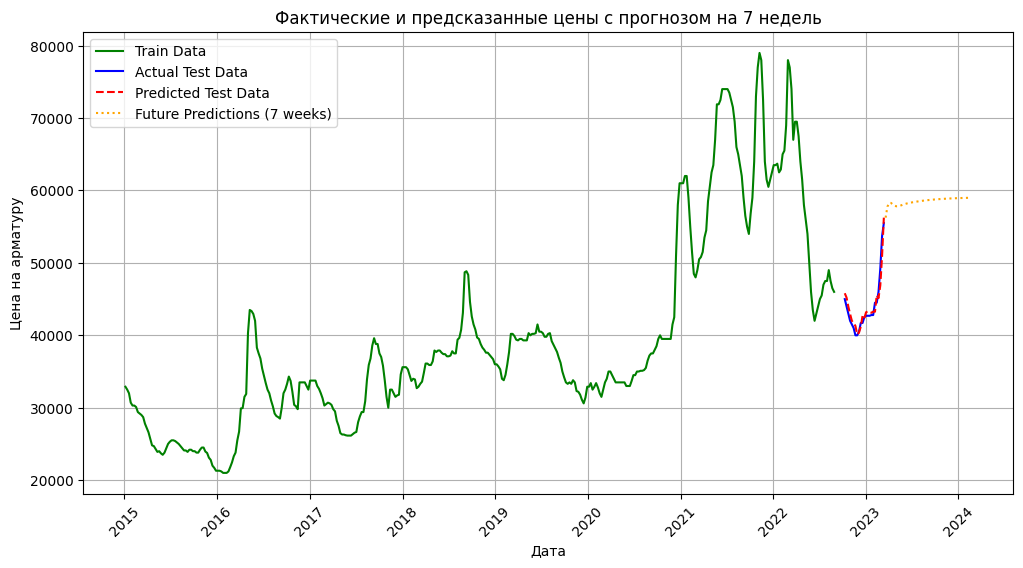

Файл с предсказаниями сохранён: predictions.xlsx


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import requests
from io import BytesIO

# Ссылки на файлы
url_train = "https://github.com/samoletpanfilov/reinforcement_task/raw/refs/heads/master/data/train.xlsx"
url_test = "https://github.com/samoletpanfilov/reinforcement_task/raw/refs/heads/master/data/test.xlsx"

# Функция загрузки данных
def load_data(url):
    response = requests.get(url)
    df = pd.read_excel(BytesIO(response.content), engine='openpyxl')
    return df

# Загружаем данные
train_data = load_data(url_train)
test_data = load_data(url_test)

# Преобразуем даты
train_data.iloc[:, 0] = pd.to_datetime(train_data.iloc[:, 0], errors="coerce")
test_data.iloc[:, 0] = pd.to_datetime(test_data.iloc[:, 0], errors="coerce")

# Проверяем, нет ли NaN после преобразования
if train_data.iloc[:, 0].isna().sum() > 0 or test_data.iloc[:, 0].isna().sum() > 0:
    raise ValueError("Ошибка: Первая колонка не содержит корректные даты!")

# Используем только "Цена на арматуру" для обучения
train_values = train_data.iloc[:, 1].values.reshape(-1, 1)
test_values = test_data.iloc[:, 1].values.reshape(-1, 1)

# Нормализация данных
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_values)
test_scaled = scaler.transform(test_values)

# Создание временных окон
def create_sequences(data, time_step=30):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

time_step = 5  # Размер окна

X_train, y_train = create_sequences(train_scaled, time_step)
X_test, y_test = create_sequences(test_scaled, time_step)

# Проверяем, не пуст ли набор данных
if X_train.shape[0] == 0 or X_test.shape[0] == 0:
    raise ValueError("Ошибка: Временные последовательности пустые. Попробуйте уменьшить time_step.")

# Преобразуем в 3D-формат для GRU/LSTM
X_train = X_train.reshape((X_train.shape[0], time_step, 1))
X_test = X_test.reshape((X_test.shape[0], time_step, 1))

# Загружаем модель
model = load_model("GRU_model.h5")

# Проверяем, совпадает ли размерность входных данных модели
expected_features = model.input_shape[-1]
actual_features = X_train.shape[-1]

if expected_features != actual_features:
    raise ValueError(f"Несовпадение признаков! Модель ожидает {expected_features}, а получили {actual_features}")

# Компилируем модель перед дообучением
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Проверяем количество данных перед обучением
if len(X_train) > 0:
    model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1)
else:
    print("Пропущено обучение: недостаточно данных.")

# Сохраняем дообученную модель в новом формате
model.save("GRU_model_updated.keras")

# Делаем предсказания, если есть данные
if len(X_test) > 0:
    y_pred = model.predict(X_test)

    # Обратное преобразование предсказаний
    y_pred_inv = scaler.inverse_transform(np.hstack((y_pred, np.zeros_like(y_pred))))[:, 0]
    y_test_inv = scaler.inverse_transform(np.hstack((y_test, np.zeros_like(y_test))))[:, 0]

    # Вычисляем метрики
    r2 = r2_score(y_test_inv, y_pred_inv)
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

    print(f"R²: {r2:.4f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}")

    # Предсказание на 7 недель вперёд
    future_predictions = []
    input_sequence = X_test[-1].copy()

    for _ in range(7 * 7):  # 7 недель (если данные понедельные)
        pred = model.predict(input_sequence.reshape(1, time_step, 1))
        future_predictions.append(pred[0, 0])
        input_sequence = np.roll(input_sequence, -1)
        input_sequence[-1] = pred

    # Обратное преобразование предсказаний на 7 недель
    future_predictions_inv = scaler.inverse_transform(np.hstack((np.array(future_predictions).reshape(-1, 1), np.zeros_like(future_predictions).reshape(-1, 1))))[:, 0]

    # Даты для будущих предсказаний
    last_date = test_data.iloc[-1, 0]
    future_dates = [last_date + pd.Timedelta(days=7 * i) for i in range(1, len(future_predictions_inv) + 1)]

    # Визуализация
    plt.figure(figsize=(12, 6))
    plt.plot(train_data.iloc[:, 0], train_values, label="Train Data", color="green")
    plt.plot(test_data.iloc[:, 0][time_step:], y_test_inv, label="Actual Test Data", color="blue")
    plt.plot(test_data.iloc[:, 0][time_step:], y_pred_inv, label="Predicted Test Data", color="red", linestyle="dashed")
    plt.plot(future_dates, future_predictions_inv, label="Future Predictions (7 weeks)", color="orange", linestyle="dotted")
    plt.legend()
    plt.title("Фактические и предсказанные цены с прогнозом на 7 недель")
    plt.xlabel("Дата")
    plt.ylabel("Цена на арматуру")
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

    # Сохранение результатов в Excel
    results_df = pd.DataFrame({
        "Дата": list(test_data.iloc[:, 0][time_step:]) + future_dates,
        "Фактическая цена": list(y_test_inv) + [None] * len(future_predictions_inv),
        "Предсказанная цена": list(y_pred_inv) + list(future_predictions_inv)
    })
    results_df.to_excel("predictions.xlsx", index=False)
    print("Файл с предсказаниями сохранён: predictions.xlsx")
else:
    print("Ошибка: Нет данных для предсказания.")

In [ ]:
pip install streamlit pandas numpy tensorflow scikit-learn matplotlib openpyxl

In [ ]:
import gradio as gr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler

# Загружаем данные
def load_data():
    file_path = "/content/GRU_predictions.csv"
    df = pd.read_csv(file_path)

    # Удаляем столбцы с датами (если они есть) и строки (объекты)
    df = df.select_dtypes(exclude=['datetime64', 'object'])

    return df

train_data = load_data()

# Подготовка данных
scaler = MinMaxScaler()
scaler.fit(train_data)

# Функция для предсказания
def predict_prices(start_date, weeks):
    start_date = pd.to_datetime(start_date)
    last_known_data = train_data.iloc[-1, :-1].values.reshape(1, -1).astype(float)
    predictions = []
    dates = [start_date + timedelta(weeks=i) for i in range(weeks)]

    for _ in range(weeks):
        scaled_input = scaler.transform(last_known_data)
        scaled_input = scaled_input[:, :-1].reshape((1, 1, -1))

        predicted_price = model.predict(scaled_input)[0, 0]

        predicted_price_inv = scaler.inverse_transform(
            np.hstack((scaled_input.reshape(1, -1), np.array([[predicted_price]])))
        )[:, -1][0]

        predictions.append(predicted_price_inv)
        last_known_data = np.hstack((last_known_data[:, 1:], np.array([[predicted_price_inv]])))

    return dates, predictions

# Функция для отображения графика и таблицы
def generate_forecast(weeks):
    # Автоматически получаем сегодняшнюю дату
    start_date = datetime.today().date()

    dates, predictions = predict_prices(start_date, weeks)

    # Создаем график
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(dates, predictions, marker="o", linestyle="dashed", label="Прогноз", color="red")
    ax.axvline(pd.to_datetime(start_date), color="gray", linestyle=":")
    ax.set_xlabel("Дата")
    ax.set_ylabel("Цена, руб.")
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.5)

    # Создаем таблицу
    forecast_df = pd.DataFrame({"Дата": dates, "Прогноз": predictions})
    return fig, forecast_df

# Интерфейс Gradio
interface = gr.Interface(
    fn=generate_forecast,
    inputs=[
        gr.Radio([7, 8], label="Выберите период прогноза (недели)", value=7)
    ],
    outputs=[
        gr.Plot(label="График прогноза"),
        gr.Dataframe(label="Таблица прогноза", headers=["Дата", "Прогноз"])
    ],
    title="Прогнозирование цены на арматуру",
    description="Выберите количество недель для прогноза. Прогноз будет начинаться с сегодняшней даты."
)

# Запуск интерфейса
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b715bd8366b2d244f4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [13]:
import tkinter as tk
from tkinter import messagebox
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# Функция для загрузки данных
def load_data():
    try:
        # Загрузка данных из CSV-файла
        data = pd.read_csv("/content/GRU_predictions.csv")
        data['Дата'] = pd.to_datetime(data['Дата'])  # Преобразование столбца 'Дата' в формат datetime

        # Переименуем столбцы для удобства
        data.rename(columns={'Реальные значения': 'real_price', 'Предсказанные значения': 'predicted_price'}, inplace=True)

        # Добавляем столбец "recommended_weeks"
        data["recommended_weeks"] = np.where(
            data["predicted_price"] > data["predicted_price"].shift(1),
            6,
            1
        )

        return data
    except FileNotFoundError:
        messagebox.showerror("Ошибка", "Файл 'lstm_predictions.csv' не найден.")
        return None
    except Exception as e:
        messagebox.showerror("Ошибка", f"Не удалось загрузить данные: {e}")
        return None

# Функция для отображения прогноза
def show_forecast():
    selected_date = date_var.get()
    if not selected_date:
        messagebox.showerror("Ошибка", "Выберите дату.")
        return

    try:
        # Поиск данных для выбранной даты
        selected_data = data[data['Дата'] == pd.to_datetime(selected_date)]
        if selected_data.empty:
            messagebox.showerror("Ошибка", "Данные для выбранной даты отсутствуют.")
            return

        predicted_value = selected_data['predicted_price'].values[0]
        recommended_weeks = selected_data['recommended_weeks'].values[0]

        result_label.config(
            text=f"Дата: {selected_date}\n"
                 f"Предсказанная цена: {predicted_value:.2f} руб./тонна\n"
                 f"Рекомендуемое количество недель для закупки: {recommended_weeks}"
        )
    except Exception as e:
        messagebox.showerror("Ошибка", f"Ошибка при поиске прогноза: {e}")

# Функция для построения графика
def plot_forecast():
    global data

    if data is None:
        messagebox.showerror("Ошибка", "Данные не загружены.")
        return

    # Создание графика
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(data['Дата'], data['predicted_price'], label='Предсказанные значения', color='red', linestyle='--')

    # Выделение рекомендаций на графике
    for i, row in data.iterrows():
        if row['recommended_weeks'] == 6:
            ax.axvline(row['Дата'], color='green', linestyle='--', alpha=0.5, label='Рекомендация: 6 недель' if i == 0 else "")
        else:
            ax.axvline(row['Дата'], color='orange', linestyle='--', alpha=0.5, label='Рекомендация: 1 неделя' if i == 0 else "")

    ax.set_xlabel("Дата")
    ax.set_ylabel("Цена на арматуру (руб./тонна)")
    ax.set_title("Предсказанные значения")
    ax.legend()

    # Отображение графика в интерфейсе
    canvas = FigureCanvasTkAgg(fig, master=graph_frame)
    canvas_widget = canvas.get_tk_widget()
    canvas_widget.pack(side=tk.TOP, fill=tk.BOTH, expand=True)
    canvas.draw()

# Основная функция для создания интерфейса
def main():
    global data, date_var, result_label, graph_frame

    # Загрузка данных
    data = load_data()
    if data is None:
        return

    # Создание главного окна
    root = tk.Tk()
    root.title("Прогноз цен на арматуру")
    root.geometry("800x600")

    # Глобальные переменные
    date_var = tk.StringVar()

    # Заголовок
    title_label = tk.Label(root, text="Прогноз цен на арматуру", font=("Arial", 16))
    title_label.pack(pady=10)

    # Выбор даты
    date_label = tk.Label(root, text="Выберите дату:")
    date_label.pack(pady=5)

    # Заполнение выпадающего списка датами
    dates = data['Дата'].dt.strftime('%Y-%m-%d').tolist()
    date_dropdown = tk.OptionMenu(root, date_var, *dates)
    date_dropdown.pack(pady=5)
    if dates:
        date_var.set(dates[0])  # Устанавливаем первую дату по умолчанию

    # Кнопка для показа прогноза
    forecast_button = tk.Button(root, text="Показать прогноз", command=show_forecast)
    forecast_button.pack(pady=10)

    # Результат прогноза
    result_label = tk.Label(root, text="", font=("Arial", 12), fg="green", justify="left")
    result_label.pack(pady=10)

    # График
    graph_frame = tk.Frame(root)
    graph_frame.pack(pady=10, fill=tk.BOTH, expand=True)

    # Кнопка для построения графика
    plot_button = tk.Button(root, text="Построить график", command=plot_forecast)
    plot_button.pack(pady=10)

    # Запуск главного цикла
    root.mainloop()

# Запуск приложения
if __name__ == "__main__":
    main()

RuntimeError: No master specified and tkinter is configured to not support default root

In [15]:
import gradio as gr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO

# Загрузка данных из Excel
def load_data():
    try:
        # Чтение Excel-файла
        data = pd.read_excel("predictions.xlsx", sheet_name="Sheet1")

        # Преобразование столбца с датой
        data['Дата'] = pd.to_datetime(data['Дата'])

        # Переименование столбцов для удобства (если нужно)
        data.rename(columns={
            'Фактическая цена': 'real_price',
            'Предсказанная цена': 'predicted_price'
        }, inplace=True)

        # Расчет рекомендуемых недель (6 если прогноз растет, иначе 1)
        data["recommended_weeks"] = np.where(
            data["predicted_price"] > data["predicted_price"].shift(1),
            6,
            1
        )
        return data
    except Exception as e:
        print(f"Ошибка при загрузке данных: {e}")
        return None

# Глобальная переменная с данными
data = load_data()

# Функция для получения прогноза по выбранной дате
def show_forecast(selected_date):
    if data is None:
        return "Ошибка: данные не загружены.", None

    try:
        selected_date = pd.to_datetime(selected_date)
        selected_data = data[data['Дата'] == selected_date]

        if selected_data.empty:
            return "Данные для выбранной даты отсутствуют.", None

        predicted_value = selected_data['predicted_price'].values[0]
        recommended_weeks = selected_data['recommended_weeks'].values[0]

        result_text = (
            f"Дата: {selected_date.strftime('%Y-%m-%d')}\n"
            f"Предсказанная цена: {predicted_value:.2f} руб./тонна\n"
            f"Рекомендуемое количество недель для закупки: {recommended_weeks}"
        )

        return result_text, plot_forecast()
    except Exception as e:
        return f"Ошибка при обработке данных: {e}", None

# Функция для построения графика
def plot_forecast():
    if data is None:
        return None

    fig, ax = plt.subplots(figsize=(10, 5))

    # Построение графика предсказанных значений
    ax.plot(data['Дата'], data['predicted_price'],
            label='Предсказанные значения', color='red', linestyle='-', linewidth=2)

    # Добавление фактических значений, если они есть
    if 'real_price' in data and not data['real_price'].isnull().all():
        ax.plot(data['Дата'], data['real_price'],
                label='Фактические значения', color='blue', linestyle='-', linewidth=2)

    # Разметка рекомендаций
    for i, row in data.iterrows():
        if row['recommended_weeks'] == 6:
            ax.axvline(row['Дата'], color='green', linestyle='--', alpha=0.3)
        else:
            ax.axvline(row['Дата'], color='orange', linestyle='--', alpha=0.3)

    ax.set_xlabel("Дата", fontsize=12)
    ax.set_ylabel("Цена на арматуру (руб./тонна)", fontsize=12)
    ax.set_title("Прогноз цен на арматуру", fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(fontsize=10)

    plt.tight_layout()
    return fig

# Получение списка доступных дат
dates = data['Дата'].dt.strftime('%Y-%m-%d').tolist() if data is not None else []

# Создание интерфейса Gradio
iface = gr.Interface(
    fn=show_forecast,
    inputs=gr.Dropdown(
        choices=dates,
        label="Выберите дату",
        value=dates[-1] if dates else None
    ),
    outputs=[
        gr.Textbox(label="Результат прогноза"),
        gr.Plot(label="График прогноза")
    ],
    title="Прогноз цен на арматуру",
    description="Выберите дату, чтобы получить прогноз цены и рекомендацию по закупке."
)

# Запуск приложения
if __name__ == "__main__":
    iface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://cda5a040d722e69cbb.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
